In [4]:
#Import packages
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import  accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,  TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.lancaster import LancasterStemmer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from pandas import Series
import networkx as nx
from PIL import Image
import seaborn as sns
import datetime as dt
import nltk, string
import pandas as pd
import numpy as np
import nltk as nlp
import datetime
import warnings
import calendar
import sys
import os
import re

In [5]:
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

#### DATA EXPLORATION

In [7]:
tweetdata = pd.read_csv('tweets.csv')
print(tweetdata.shape)

(6444, 28)


In [8]:
tweetdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6444 entries, 0 to 6443
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       6444 non-null   int64  
 1   handle                   6444 non-null   object 
 2   text                     6444 non-null   object 
 3   is_retweet               6444 non-null   bool   
 4   original_author          722 non-null    object 
 5   time                     6444 non-null   object 
 6   in_reply_to_screen_name  208 non-null    object 
 7   in_reply_to_status_id    202 non-null    float64
 8   in_reply_to_user_id      208 non-null    float64
 9   is_quote_status          6444 non-null   bool   
 10  lang                     6444 non-null   object 
 11  retweet_count            6444 non-null   int64  
 12  favorite_count           6444 non-null   int64  
 13  longitude                12 non-null     float64
 14  latitude                

In [5]:
#Check variables
tweetdata.columns

Index(['id', 'handle', 'text', 'is_retweet', 'original_author', 'time',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'is_quote_status', 'lang', 'retweet_count',
       'favorite_count', 'longitude', 'latitude', 'place_id',
       'place_full_name', 'place_name', 'place_type', 'place_country_code',
       'place_country', 'place_contained_within', 'place_attributes',
       'place_bounding_box', 'source_url', 'truncated', 'entities',
       'extended_entities'],
      dtype='object')

In [10]:
#Setting the timestamp
tweetdata['time_decoded'] = pd.to_datetime(tweetdata.time)
tweetdata['time_decoded'] = tweetdata.time_decoded.map(lambda x: x.strftime('%Y-%m-%d'))
tweetdata[['time', 'time_decoded']].head()

,time,time_decoded
0,2016-09-28T00:22:34,2016-09-28
1,2016-09-27T23:45:00,2016-09-27
2,2016-09-27T23:26:40,2016-09-27
3,2016-09-27T23:08:41,2016-09-27
4,2016-09-27T22:30:27,2016-09-27


HillaryClinton     3226
realDonaldTrump    3218
Name: handle, dtype: int64


<AxesSubplot:>

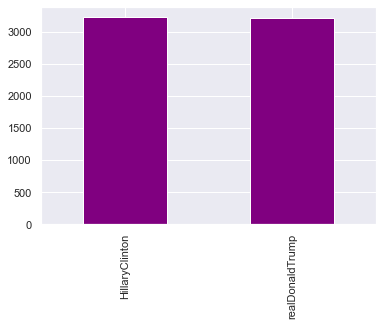

In [41]:
#Class balance checking
print(tweetdata.handle.value_counts())
tweetdata.handle.value_counts().plot(kind='bar', color='purple')

TRENDS IN TWEETS OVER TIME

In [17]:
#Creating a variable to calculate the number of daily tweets per candidate
tweetdata['count']= 1
groupdata = tweetdata.groupby(['time_decoded', 'handle'])
groupdata = groupdata['count'].sum().reset_index()

In [18]:
groupdata.head(5)

,time_decoded,handle,count
0,2016-01-05,realDonaldTrump,9
1,2016-01-06,realDonaldTrump,18
2,2016-01-07,realDonaldTrump,14
3,2016-01-08,realDonaldTrump,14
4,2016-01-09,realDonaldTrump,10


<AxesSubplot:title={'center':'Timeline: Distribution of Tweets'}, xlabel='time_decoded'>

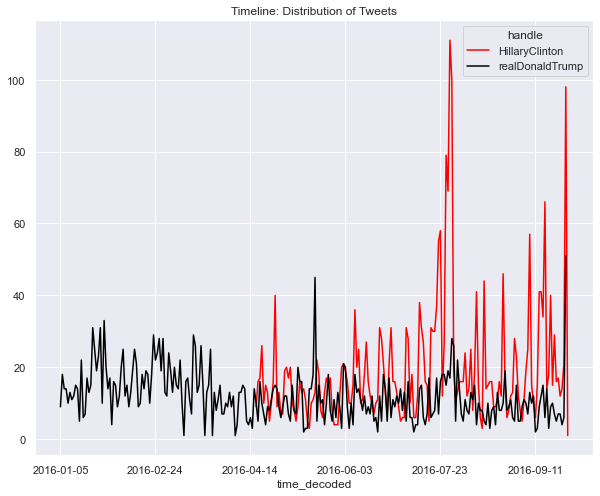

In [39]:
# Viewing tweets over time
groupdata.pivot(index='time_decoded', columns='handle', values='count').plot(figsize=(10, 8), color=['red','black'], title='Timeline: Distribution of Tweets')

In [20]:
#Generating timestamps
tweetdata['time'] = pd.to_datetime(tweetdata.time)
tweetdata['date']= tweetdata.time.apply(lambda x: x.date())
tweetdata['week']= tweetdata.time.apply(lambda x: x.isocalendar()[1])
tweetdata['tweethour'] = tweetdata.time.apply(lambda x: (x).hour)

In [21]:
# Filtering retweets and dates after 4/15/2016
tweetdata_rt = tweetdata[(tweetdata['is_retweet'] == False) & (tweetdata['date'] >= pd.to_datetime('2016-04-15').date())]
tweetdata_rt_daily = tweetdata_rt.groupby(['date', 'handle']).size().unstack()
data_rt_weekly = tweetdata_rt.groupby(['week', 'handle']).size().unstack()

<AxesSubplot:title={'center':'Daily Count of Tweets'}, xlabel='date'>

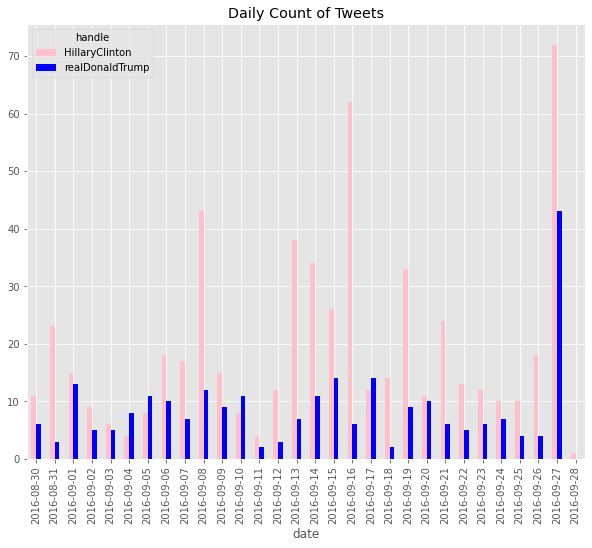

In [30]:
# plot the timeseries for daily number of tweets
tweetdata_rt_daily.tail(30).plot(kind='bar', color= ['pink', 'blue'],title='Daily Count of Tweets', figsize=(10, 8) )

<AxesSubplot:title={'center':'Weekly Tweet Counts'}, xlabel='week'>

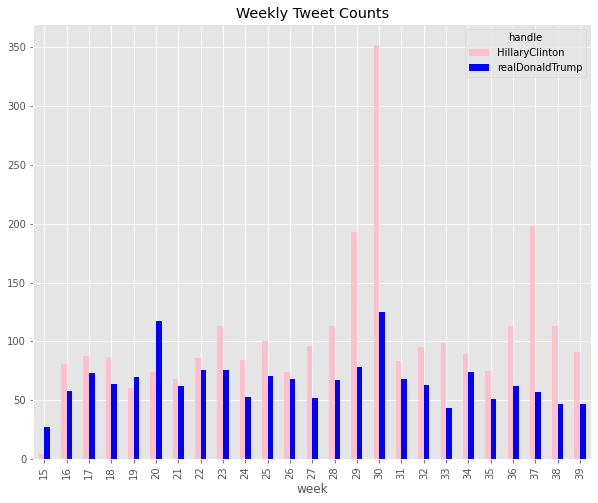

In [31]:
#plot the timeseries for weekly number of tweets
data_rt_weekly.plot(kind='bar',color= ['pink', 'blue'], title='Weekly Tweet Counts', figsize=(10, 8))

#### MONTHLY TREND OF TWEETS

<AxesSubplot:title={'center':'Trend in Monthly Tweet Counts'}, xlabel='month'>

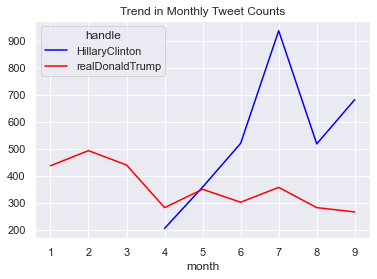

In [37]:
tweetdata['month'] = tweetdata['time'].apply(lambda x: x.month)
sns.set(font_scale=1)
monthlytweets = tweetdata.groupby(['month', 'handle']).size().unstack()
monthlytweets.plot(title='Trend in Monthly Tweet Counts', color = ['blue', 'red'])

#### Exploring Candidate Tweet times

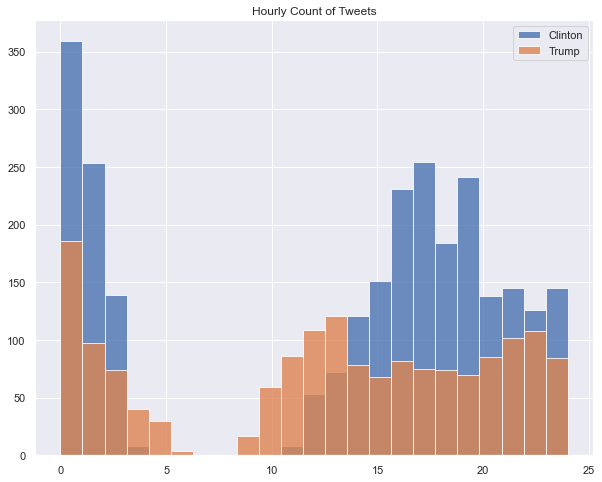

In [44]:
bins = np.linspace(0, 24, 24)
plt.figure(figsize=(10, 8))
plt.hist(tweetdata_rt['tweethour'][tweetdata_rt['handle']=='HillaryClinton'], bins, alpha=0.8, label="Clinton")
plt.hist(tweetdata_rt['tweethour'][tweetdata_rt['handle']=='realDonaldTrump'], bins, alpha=0.8, label="Trump")
plt.legend()
plt.title('Hourly Count of Tweets')
plt.show()

 <a id="42"></a> <br>

### Analysis of Retweets 


[[Text(0, 0, 'Tweets'), Text(1, 0, 'Retweets')]]

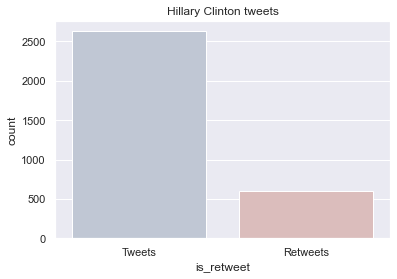

In [45]:
#Original vs retweets :Clinton 
h_retweet = tweetdata.loc[(tweetdata['handle']=='HillaryClinton'), ['is_retweet']]
ax1 = sns.countplot(h_retweet['is_retweet'], palette='vlag')
ax1.set_title("Hillary Clinton tweets")
ax1.set(xticklabels=["Tweets","Retweets"])

[[Text(0, 0, 'Tweets'), Text(1, 0, 'Retweets')]]

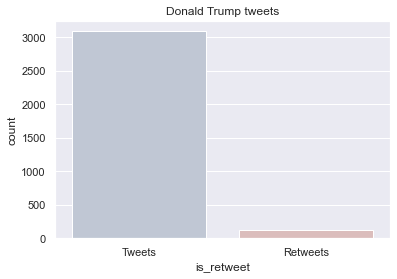

In [46]:
#Original vs retweets :Trump
t_retweet = tweetdata.loc[(tweetdata['handle']=='realDonaldTrump'), ['is_retweet']]
ax2 = sns.countplot(t_retweet['is_retweet'], palette='vlag')
ax2.set_title("Donald Trump tweets")
ax2.set(xticklabels=["Tweets","Retweets"])

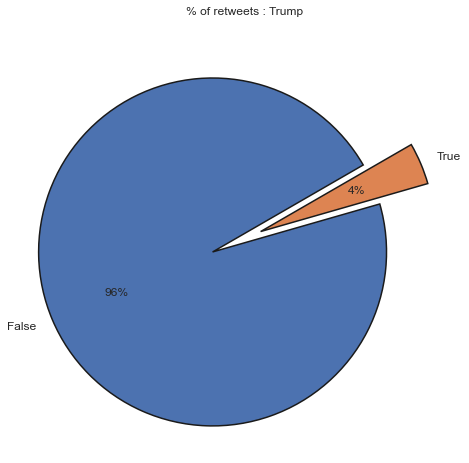

In [52]:
plt.figure(figsize = (10,8))
tweetdata[tweetdata["handle"] ==
       "realDonaldTrump"]["is_retweet"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                                wedgeprops = {"linewidth" : 1.5,
                                                                              "edgecolor" : "k"},
                                                                fontsize = 12,
                                                                explode = [.2,0.1],
                                                                startangle = 30
                                                               )
plt.ylabel("")
plt.title("% of retweets : Trump")
plt.show()

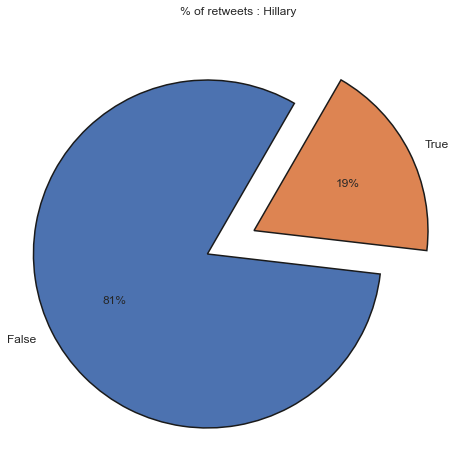

In [51]:
plt.figure(figsize = (10,8))
tweetdata[tweetdata["handle"] ==
       "HillaryClinton"]["is_retweet"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                                wedgeprops = {"linewidth" : 1.5,
                                                                              "edgecolor" : "k"},
                                                                fontsize = 12,
                                                                explode = [.2,0.1],
                                                                startangle = 60
                                                               )
plt.ylabel("")
plt.title("% of retweets : Hillary")
plt.show()

 <a id="5"></a> <br>



#### Analysing Trump and Clinton Tweets

In [53]:
tweets_dt = [' '.join(t.strip().split()) for t in tweetdata[tweetdata.handle=='realDonaldTrump'].text.tolist()]
tweets_hc = [' '.join(t.strip().split()) for t in tweetdata[tweetdata.handle=='HillaryClinton'].text.tolist()]

#### Defining stop words to be excluded

In [54]:
stopwords = set(STOPWORDS)
stopwords.add("http")
stopwords.add("https")
stopwords.add("amp")
stopwords.add("CO")
stopwords.add("Trump")
stopwords.add("Trump2016")
stopwords.add("Donald")
stopwords.add("Clinton")
stopwords.add("Hillary")
stopwords.add("Hillary'")
stopwords.add("realDonaldTrump")
stopwords.add("will")
stopwords.add("say")
stopwords.add("said")
stopwords.add("let")
stopwords.add("vote")
stopwords.add("now")
stopwords.add("go")

TRUMP WordCloud

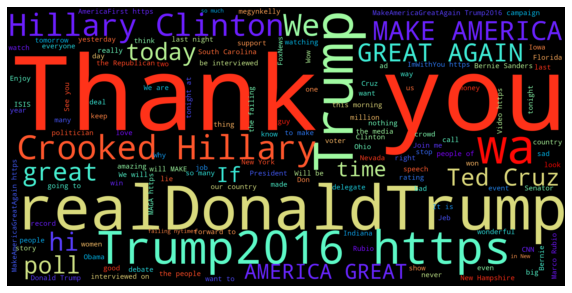

In [62]:
dt_wordcloud = WordCloud(max_font_size=100, max_words=1000, scale=6, relative_scaling=.6,stopwords=stopwords, background_color="black", colormap = "rainbow").generate(str(tweets_dt))
plt.figure(figsize=(10,8))
plt.imshow(dt_wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

Hillary Clinton Word Cloud

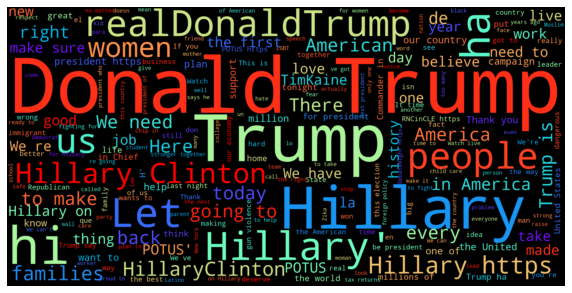

In [59]:
hc_wordcloud = WordCloud(max_font_size=100, max_words=1000, scale=6, relative_scaling=.6,stopwords=stopwords, background_color="black", colormap = "rainbow").generate(str(tweets_hc))
plt.figure(figsize=(10,8))
plt.imshow(hc_wordcloud ,interpolation="bilinear")
plt.axis("off")
plt.show()

#### SENTIMENT ANALYSIS OF TWEETS

 ### Clinton Sentiment analysis

In [68]:
#Clinton Tweet Sentiment
tweetclinton = tweetdata.loc[(tweetdata['handle']=='HillaryClinton'), ['text']]
bloblist_desc = list()

tweetclintonstr=tweetclinton['text'].astype(str)
for row in tweetclintonstr:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    tweetclinton_polarity = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])

    
def f(tweetclinton_polarity):
    if tweetclinton_polarity['sentiment'] > 0:
        val = "Positive"
    elif tweetclinton_polarity['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

tweetclinton_polarity['Clinton Sentiments'] = tweetclinton_polarity.apply(f, axis=1)


#Trump Tweet Sentiment
tweettrump = tweetdata.loc[(tweetdata['handle']=='realDonaldTrump'), ['text']]
bloblist_desc = list()

tweettrumpstr=tweettrump['text'].astype(str)
for row in tweettrumpstr:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    tweettrump_polarity = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])

    
def f(tweettrump_polarity):
    if tweettrump_polarity['sentiment'] > 0:
        val = "Positive"
    elif tweettrump_polarity['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

tweettrump_polarity['Trump Sentiments'] = tweettrump_polarity.apply(f, axis=1)

### Plot: Comparing Sentiments

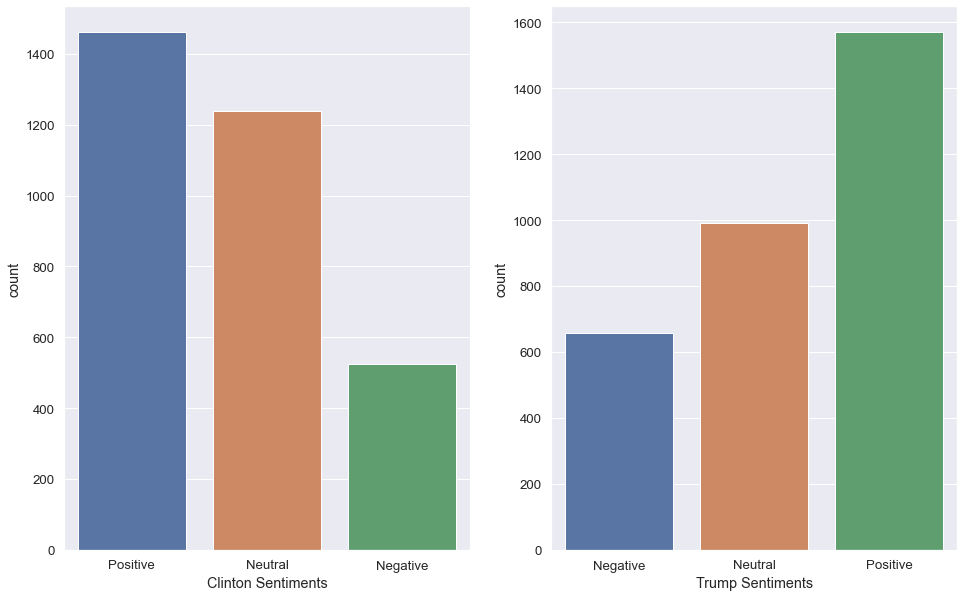

In [69]:
fig, ax =plt.subplots(1,2,figsize=(16,10))
sns.set_style("whitegrid")
sns.set(font_scale=1.2)
sns.countplot(x="Clinton Sentiments", data=tweetclinton_polarity,  ax=ax[0])
sns.countplot(x="Trump Sentiments", data=tweettrump_polarity, ax=ax[1])
fig.show()